# Navios

**Grupo 7:**

- Luís Almeida A84180
- João Pedro Antunes A86813 

Pretende-se construir um  autómato híbrido que modele uma situação definida por 3 navios a navegar num lago infinito. Cada navio é caracterizado pela sua posição no plano $\,(x,y)\,$, a sua rota medida num ângulo com o eixo horizontal em unidades de $15^o$, e uma velocidade que assume apenas 2 valores:  $1\, \texttt{m/s}\,$ (“low”) e $\,10\,\mathtt{m/s}\,$ (“high”).
   - Os navios conhecem o estado uns dos outros.
   - Na presença de uma eminente colisão entre dois navios (ver notas abaixo) , ambos os navios passam à velocidade “low” e mudam a rota, para bombordo (esquerda)  ou estibordo (direita) em não mais que uma unidade de $\,15^o$. Após se afastarem para uma distância de segurança  regressam à velocidade “high”.
   - Pretende-se verificar que realmente os navios navegam sem colisões.

## Modelação do Problema num Autómato Híbrido

Vamos então modelar a situação apresentada num autómato híbrido fazendo a distinção entre a componente discreta e a componente contínua. Vamos descrever cada navio como um triplo $(x,y,t)$ em que $x$ e $y$ correspondem à posição no plano do navio e $t$ corresponde ao tempo relativo desse navio. Em termos discretos, temos o seguinte:

- $3$ modos, **INIT, HIGH, LOW**;

- 24 rotações discretas, descrevendo os ângulos de $0^\circ$ a $345^\circ$ em intervalos regulares de $15^\circ$;

Podemos dividir cada um dos modos em sub-modos consoante a inclinação (rota) do navio. Sendo assim, para representarmos os modos de **um único** navio no problema proposto, precisamos de pelo menos $24 \times 3 = 72$ estados. Como resultado, teremos $72^{N}$ estados, onde $N$ é o número de navios do sistema. Vamos descrever todos os $N$ navios em todas as combinações de estados possíveis, e conjugando as condições de transição.
Ora, em termos contínuos, temos:

- $(x,y)$ que representam as coordenadas de cada navio

- $t$ que representa o tempo relativo a cada navio

Mais tarde apresentaremos o *flow* e as transições *timed* e *untimed*.


Para modelarmos este autómato num FOTS e de seguida podermos demonstrar propriedades sobre ele, vamos necessitar de uma variável $x$, $y$ e $t$ contínua, bem como uma variável discreta que indique o modo e uma outra que indique a inclinação de cada navio. De seguida apresenta-se uma função que declara as variáveis de cada estado:

In [1]:
from z3 import *
import math

ships = 3 #número de navios
maxDegs = 15 #valor do intervalo da inclinação do navio
divsDegs = 360//maxDegs #número de intervalos c a dada inclinação
risk = 20 #coeficiente de risco
vMax = 10 #velocidade máxima do navio
vMin = 1 #velocidade mínima do navio


inclin = [maxDegs*x for x in range(divsDegs)] #todas as inclinações possíveis

Mode, (LOW,HIGH,INIT) = EnumSort('Mode', ('LOW','HIGH','INIT')) #modo de operação do navio

def declare(i):
    s = {}
    for ship in range(ships): #cada navio tem as suas variáveis
        s[ship] = {}
        s[ship]['x'] = Real(str(ship)+' X '+str(i)) 
        s[ship]['y'] = Real(str(ship)+' Y '+str(i))
        s[ship]['route'] = Int(str(ship)+' R '+str(i))
        s[ship]['mode'] = Const(str(ship)+' M '+str(i),Mode)
        s[ship]['time'] = Real(str(ship) + ' T '+str(i))
    return s

Temos agora de implementar o predicado que inicializa o FOTS. Como tal, vamos olhar para o que pretendemos que aconteça como situação inicial do nosso sistema:

- O modo de cada navio terá de ser o modo $INIT$, bem como o seu tempo terá de ser $0$:

$$
mode == INIT \wedge t == 0
$$

- O navio toma um sub-modo, ou seja, o navio apresenta uma inclinação válida conforme descrito anteriormente:

$$
\bigvee_{\rho} route == \rho, \quad \forall \rho \in inclin
$$

- Navios diferentes não podem ter a mesma posição, ou seja, dado um navio A:

$$
navioA_{x} \ne navioB_{x} \vee navioA_{y} \ne NavioB_{y}, \quad \text{para todo o navioB}
$$

O predicado $init$ será então uma conjunção de todos estes "sub-predicados" aplicados a todos os navios. De seguida apresenta-se a implementação do mesmo:

In [2]:
def init(state):
    startMode = [(state[ship]['mode']) == INIT for ship in range(ships)] #os barcos inicializam em estado INIT
    startTime = [(state[ship]['time'] == 0) for ship in range(ships)] #o tempo inicial de cada barco é 0
    
    startRoute = []
    for ship in range(ships):
        pred = Or([state[ship]['route'] == ang for ang in inclin]) #garante que a rota é inicializada com um ângulo
        startRoute.append(pred)

    startPos = [] #garante que barcos diferentes não têm a mesma posição
    for A in range(ships):
        for B in range(ships):
            if A > B:
                pred = Or(state[A]['x'] != state[B]['x'], state[A]['y'] != state[B]['y']) 
                startPos.append(pred)

    cond = startMode + startTime + startRoute + startPos 
    return And(cond)

Vamos então definir as transições do FOTS. Para este efeito, temos de completar a nossa definição do autómato com os *flows* e com as transições *timed* e *untimed*. Tendo em conta a modelação anteriormente feita dos estados discretos, podemos então analisar as componentes contínuas do autómato começando por definir o flow em cada modo. Sabemos que a variável $V$ de velocidade do navio pode ser interpretada como uma constante interna a cada estado *HIGH* e *LOW*, assim, o deslocamento total do navio seria representado por, 

$$
\Delta = v\cdot |t_{1} - t_{0}|
$$

com $V$ constante a $1$ ou $10$, e $\Delta$ o deslocamento total do navio.
O deslocamento em cada componente, entretanto, será dado por uma relação entre $\Delta$ e os valores de seno e cosseno do ângulo associado à rota do navio, que é descrita pelo seguinte sistema de equações:

$$
\begin{cases} \Delta_x = \Delta \cdot cos(\rho)
\\
\\ \Delta_y = \Delta \cdot sin(\rho) 
\end{cases}
$$

sendo $\rho$ a inclinação do navio, também constante consoante o estado discreto "ativo" do autómato de cada navio. Sendo assim, o flow em cada modo será representado (mas não unicamente) por uma conjunção dos sistemas de equações (todas as equações acima são lineares e contínuas) de cada navio que determinam o seu deslocamento. Definimos então a primeira restrição no *z3*, para a ocorrência de uma transição *timed*.

In [3]:
def deltaXY(now,prox,ship,vel):
    p = []
    for angle in inclin:
        angVer = (now[ship]['route'] == angle)
        deltaX = (prox[ship]['x'] - now[ship]['x'] == cosseno(angle)*vel*(prox[ship]['time'] - now[ship]['time']))
        deltaY = (prox[ship]['y'] - now[ship]['y'] == seno(angle)*vel*(prox[ship]['time'] - now[ship]['time']))
        p.append(And(angVer,deltaX,deltaY))
    return Or(p)


def cosseno(ang):
    return math.cos(math.radians(ang))

def seno(ang):
    return math.sin(math.radians(ang))

No entanto, temos de adicionar ao *flow* a condição que não permite a ocorrência de uma transição *timed* enquanto o navio se encontra dentro da distância de risco. É de conhecimento no problema que um navio apenas transita entre os estados de velocidade e rotação consoante uma colisão iminente, dada por uma constante de risco para representar uma distância de segurança entre os navios.
Tendo a distância de segurança ($r$) poderíamos calcular uma colisão iminente (ou uma invasão do espaço de segurança) pela fórmula simples de distância entre pontos:

$$
D(P_0,P_1) = (x_0 - x_1)^2 + (y_0 - y_1)^2 
\\\wedge
\\D(P_0,P_1)\leq r
$$

A fórmula proposta, entretanto, não se aplica a equações lineares, levando à indecisão do problema. A solução mais adequada seria, então, trabalharmos com a distância um pouco menos restrita do que a descrita. Se a fórmula anterior descrevia uma circunferência para a distância entre os pontos, descreveremos nossa distância com um quadrado tangente a esta circunferência (isto é, que tenha a circunferência inscrita em seu interior). Definiremos então:

$$
D(P_0,P_1) = max\{|(x_0 - x_1)|,|(y_0 - y_1)|\}
\\\wedge
\\D(P_0,P_1)\leq r
$$

Temos ainda que levar em conta a velocidade da movimentação dos barcos, considerando que, com a existência de eventos assíncronos, os barcos não podem estar no mesmo ponto em tempos próximos, mas não necessariamente iguais. Por fim, então, teremos:

$$
D(P_0,P_1) = max\{|(x_0 - x_1)|,|(y_0 - y_1)|,v|t_0 - t_1|\}
\\\wedge
\\D(P_0,P_1)\leq r
$$

Descrevemos, então, o obtido, em *z3*:

In [4]:
def modLess(x,z,r):
    return And((x <= z + r), (z <= x + r))

def distance(state,boatA,boatB,const,vMed):
    xDif = modLess(state[boatA]['x'],state[boatB]['x'],const)
    yDif = modLess(state[boatA]['y'],state[boatB]['y'],const)
    tDif = modLess(state[boatA]['time'],state[boatB]['time'],const/vMed)
    return And(xDif,yDif,tDif)

Basta então garantirmos como condição de um dado navio $N$ fazer uma transição *timed* que:  

$$
\neg (\forall S \in Navios \cdot ( S \neq N \rightarrow D(N,S) \leq r ))
$$

Teremos então, a tradução da fórmula que determina se o navio está em distância de risco em *z3*:

In [5]:
def iminColis(state,boat):
    iminente = [distance(state,boat,target,risk,vMax) for target in range(ships) if target != boat]
    return Or(iminente)

Podemos agora, então, definir as transições *timed* do problema, as que não apresentam mudança de estados discretos, apenas passagem de tempo e deslocamento dos barcos, com variações contínuas. Nesta transição verificamos se o deslocamento do navio foi condizente com as regras apresentadas, que o deslocamento não violou as regras de mudança de estado de velocidade impostas anteriormente e que não existe nenhuma colisão iminente:

In [6]:
def timed(now,prox,ship):
    predLow = And(now[ship]['mode'] == LOW, now[ship]['mode'] == prox[ship]['mode'], prox[ship]['time'] > now[ship]['time'], now[ship]['route'] == prox[ship]['route'], deltaXY(now,prox,ship,vMin),Not(iminColis(prox,ship)))
    
    predHigh = And(now[ship]['mode'] == HIGH, now[ship]['mode'] == prox[ship]['mode'], prox[ship]['time'] > now[ship]['time'], now[ship]['route'] == prox[ship]['route'], deltaXY(now,prox,ship,vMax), Not(iminColis(prox,ship)))    
    
    return Or(predLow,predHigh)

Vamos agora definir as transições *untimed*. Estas transições são eventos assíncronos que ocorrem entre os diferentes modos e sub-modos consoante determinadas condições. De seguida apresenta-se uma ilustração (não muito fiel) de um exemplo de um autómato com **rotações discretas de $90^\circ$**, nas mesmas condições descritas, para **um único** navio, (ciano = *HIGH*, vermelho = *LOW* e azul = *INIT*):

![automato de um único navio com rotações de 90°](automato1.png)

Ilustrada a situação com o anterior autómato teríamos de adaptar para nosso caso com rotações de $15^\circ$.
Comecemos por definir as condições de transição *untimed* entre os ângulos das rotas dos navios. Antes de definirmos as interações entre estados de velocidade e rota comecemos apenas por garantir as regras básicas acerca das rotações. Isto é, garantir que cada rotação executada não passe de $15^\circ$ e que a rota resultante esteja compreendida entre $0^\circ$ e $345^\circ$, temos então a seguinte restrição para modelarmos:

$$
\begin{cases} \rho' = (\rho + 15) \mod 360 
\\\quad\quad\vee
\\\rho' = (\rho - 15) \mod 360
\end{cases}
$$

Com $\rho$ a rota atual do navio, e $\rho'$ a rota do estado seguinte. A restrição descrita não é modelável em *z3* por se utilizar da operação módulo. Porém, como cada rota é um sub-modo, então sabemos que $\rho$ é constante, tornando assim a operação $(\rho \pm 15) \mod{360}$ exequível.  

In [7]:
def validRot(now,prox,boat):
    valid = []
    
    for ang in inclin:
        left = (ang + maxDegs) % 360
        right = (ang - maxDegs) % 360
        pred = And(now[boat]['route'] == ang, Or(prox[boat]['route'] == left, prox[boat]['route'] == right))
        valid.append(pred)
    return Or(valid)

Temos então definidas todos os requisitos para descrevermos as transições *untimed* do sistema. Estas transições representam apenas mudanças discretas denotadas por uma mudança no *flow* do autómato de um navio. Queremos que o FOTS tenha o comportamento seguinte:

- $trans(init,high)$: acontece quando não existe uma colisão iminente 


- $trans(init,low)$: acontece quando existe uma colisão iminente


- $trans(high,low)$: acontece quando existe uma colisão iminente


- $trans(low,high)$: acontece quando não existe uma colisão iminente

Temos então descrito:

In [8]:
def untimed(now,prox,ship):
    init_high = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], Not(iminColis(prox,ship)), now[ship]['mode'] == INIT, prox[ship]['mode'] == HIGH, now[ship]['route'] == prox[ship]['route'])
    
    init_low = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], iminColis(prox,ship), now[ship]['mode'] == INIT, prox[ship]['mode'] == LOW,validRot(now,prox,ship))
    
    high_low = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], iminColis(prox,ship), now[ship]['mode'] == HIGH, prox[ship]['mode'] == LOW,validRot(now,prox,ship))
    
    low_high = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], Not(iminColis(prox,ship)), now[ship]['mode'] == LOW, prox[ship]['mode'] == HIGH, now[ship]['route'] == prox[ship]['route'])  
    
    return Or(init_high,init_low,high_low,low_high)

Ou seja, para cada transição *untimed* possível, verificamos que as variáveis contínuas matém-se, e que as discretas tomam um valor válido consoante as condições apresentadas sobre os módulos de velocidade e rotação.

E por fim, para unificarmos todas as transições de todos os navios envolvidos no sistema, criamos uma transição única que envolve todos os navios e obriga a execução de uma transição *timed* ou *untimed* por barco. Teremos então: 

In [9]:
def trans(now,prox):
    actions = []
    for ship in range(ships):
        actions.append(Or(timed(now,prox,ship),untimed(now,prox,ship)))
    return And(actions)

Tendo então as devidas restrições definidas nas transições do autómato construído, podemos agora definir uma função de geração de traços, em que se gera um conjunto de $k$ estados, e garantimos que entre cada dois pares de estados consecutivos há uma relação de transição. Isto é:

$$ trans( \alpha_{i} , \alpha_{i+1}), \quad \forall 0 \le i \le k-1 $$

In [10]:
def gera_traco(declare,init,trans,k):
    trace = [declare(i) for i in range(k)]
    s = Solver()
    
    s.add(init(trace[0]))
    
    for i in range(k-1):
        s.add(trans(trace[i],trace[i+1]))
    
    r = s.check()
    if r == sat:
        m = s.model()
        for i in range(k):
            print("==========\n\n\nstate: ",i)
            for v in trace[i]:
                for h in trace[i][v]:
                    if trace[i][v][h].sort() != RealSort():
                        print(v,h, "=", m[trace[i][v][h]])
                    else:
                        print(v,h, '=', float(m[trace[i][v][h]].numerator_as_long())/float(m[trace[i][v][h]].denominator_as_long()))
                print("\n")
        return
    
    print('UNSAT')
    return 


gera_traco(declare,init,trans,6)



state:  0
0 x = -14.64466094067262
0 y = -7.26017904234912
0 route = 60
0 mode = INIT
0 time = 0.0


1 x = -13.64466094067262
1 y = 12.739820957650881
1 route = 225
1 mode = INIT
1 time = 0.0


2 x = -12.64466094067262
2 y = 32.73982095765088
2 route = 315
2 mode = INIT
2 time = 0.0




state:  1
0 x = -14.64466094067262
0 y = -7.26017904234912
0 route = 45
0 mode = LOW
0 time = 0.0


1 x = -13.64466094067262
1 y = 12.739820957650881
1 route = 240
1 mode = LOW
1 time = 0.0


2 x = -12.64466094067262
2 y = 32.73982095765088
2 route = 330
2 mode = LOW
2 time = 0.0




state:  2
0 x = 0.0
0 y = 7.384481898323501
0 route = 45
0 mode = LOW
0 time = 20.710678118654748


1 x = -20.5
1 y = 0.8660254037844385
1 route = 240
1 mode = LOW
1 time = 13.710678118654746


2 x = 2.6932362283315734
2 y = 23.8844818983235
2 route = 330
2 mode = LOW
2 time = 17.710678118654748




state:  3
0 x = 0.0
0 y = 7.384481898323501
0 route = 45
0 mode = HIGH
0 time = 20.710678118654748


1 x = -21.0
1 y = 0.0
1

## Verificação de que não existem colisões

Temos agora de verificar que não existem colisões no sistema modelado. Como estamos a trabalhar sobre um FOTS, podemos usar o procedimento *BMC* para verificar propriedades em traços limitados do programa com $k$ estados diferentes. Como tal, temos simplesmente de definir a propriedade que indica que não existe uma colisão. Basta garantirmos que, para quaisquer $2$ navios $S$ e $D$, caso o tempo deles seja igual, então não estão na mesma posição. Temos então:

$$
\forall_{S,D}\cdot (S_{t} == D_{t}) \rightarrow (S_{x} \ne D_{x} \vee S_{y} \ne D_{y}), \quad S \ne D 
$$

De seguida apresenta-se a tradução desta propriedade em z3:

In [11]:
def prop(state):
    startPos = []
    for A in range(ships):
        for B in range(ships):
            if A > B:
                pred = Implies(state[A]['time'] == state[B]['time'],
        Or(state[A]['x'] != state[B]['x'], state[A]['y'] != state[B]['y'])) 
                startPos.append(pred)

    return And(startPos)

In [12]:
def bmc_always(declare,init,trans,inv,K):
    for k in range(1,K+1):
        s = Solver()
        trace = [declare(i) for i in range(k)]
        s.add(init(trace[0]))
        for i in range(k - 1):
            s.add(trans(trace[i], trace[i + 1]))
        s.add(Not(inv(trace[k - 1])))
        if s.check() == sat:
            m = s.model()
            for i in range(k):
                print("==========\n\n\nstate: ",i)
                for v in trace[i]:
                    if v != 'time':
                        for h in trace[i][v]:
                            if trace[i][v][h].sort() != RealSort():
                                print(v,h, "=", m[trace[i][v][h]])
                            else:
                                print(v,h, '=', float(m[trace[i][v][h]].numerator_as_long())/float(m[trace[i][v][h]].denominator_as_long()))
                    else:
                        print(v, '=', float(m[trace[i][v]].numerator_as_long())/float(m[trace[i][v]].denominator_as_long()))
                    print("\n")
            return
        
    print ("Property is valid up to traces of length "+str(K))
    return

bmc_always(declare,init,trans,prop,5)

Property is valid up to traces of length 5


## Ilustração de estados válidos de um sistema

A fim de ilustrar algumas situações e visualizar mais facilmente os estados de um traço do sistema, desenvolveu-se uma variação ao sistema pedido. Nesta variação, é utilizado um "tempo global" que varia igualmente para todos os barcos em todos os estados.
Com esta variação torna-se possível a geração de uma componente gráfica para acompanhar o presente estado do navios em um plano cartesiano.

Para tanto, utilizaremos as *libraries* de python *matplotlib* e *numpy*

A seguir, apresentamos o código para a geração pretendida:

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math


ships = 3 #número de navios
maxDegs = 15 #valor do intervalo da inclinação do navio
divsDegs = 360//maxDegs #número de intervalos c a dada inclinação
risk = 5 #coeficiente de risco
vMax = 10 #velocidade máxima do navio
vMin = 1 #velocidade mínima do navio

A maior diferença nesta variação apresenta-se a seguir, na função de transição, onde garantimos que os navios estejam todos sincronizados, isto é, apresentam o mesmo tempo em todos os estados. 

Nesta função de transição também, foi adicionada uma nova transição *untimed* que permite a constância de um navio em um dado estado, esta adição faz-se necessária pelo que se o tempo de todos os navios deve ser igual, navios não afetados por uma colisão iminente não sofrem alterações em funções *untimed*, podendo permanecer constante durante a troca de estados dos demais navios.

In [14]:
def trans(now,prox):
    actions = []
    for ship in range(ships):
        predLow = And(now[ship]['mode'] == LOW, now[ship]['mode'] == prox[ship]['mode'], prox[ship]['time'] > now[ship]['time'], now[ship]['route'] == prox[ship]['route'], deltaXY(now,prox,ship,vMin),Not(iminColis(prox,ship))) 
        predHigh = And(now[ship]['mode'] == HIGH, now[ship]['mode'] == prox[ship]['mode'], prox[ship]['time'] > now[ship]['time'], now[ship]['route'] == prox[ship]['route'], deltaXY(now,prox,ship,vMax), Not(iminColis(prox,ship)))
        timed = Or(predLow,predHigh)


        init_high = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], Not(iminColis(prox,ship)), now[ship]['mode'] == INIT, prox[ship]['mode'] == HIGH, now[ship]['route'] == prox[ship]['route'])
        init_low = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], iminColis(prox,ship), now[ship]['mode'] == INIT, prox[ship]['mode'] == LOW,validRot(now,prox,ship))
        high_low = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], iminColis(prox,ship), now[ship]['mode'] == HIGH, prox[ship]['mode'] == LOW,validRot(now,prox,ship))
        low_high = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], Not(iminColis(prox,ship)), now[ship]['mode'] == LOW, prox[ship]['mode'] == HIGH, now[ship]['route'] == prox[ship]['route'])
        const = And(prox[ship]['time'] == now[ship]['time'], prox[ship]['x'] == now[ship]['x'], prox[ship]['y'] == now[ship]['y'], now[ship]['route'] == prox[ship]['route'], Not(iminColis(prox,ship)), now[ship]['mode'] == prox[ship]['mode'], now[ship]['mode'] == HIGH)
        untimed = Or(init_high,init_low,high_low,low_high,const)

        actions.append(Or(timed,untimed))

    
    return And(actions)


A seguir, apresentam-se as funções responsáveis por fazer o "plot" e gerar um traço compatível.



state:  0
0 x = -135.06434875486053
0 y = 117.27052836400652
0 route = 315
0 mode = INIT
0 time = 0.0


1 x = 7.9107564457231385
1 y = 13.70183209029545
1 route = 225
1 mode = INIT
1 time = 0.0


2 x = 8.306294268009296
2 y = 18.701832090295447
2 route = 195
2 mode = INIT
2 time = 0.0




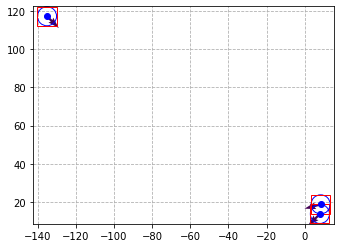



state:  1
0 x = -135.06434875486053
0 y = 117.27052836400652
0 route = 315
0 mode = HIGH
0 time = 0.0


1 x = 7.9107564457231385
1 y = 13.70183209029545
1 route = 240
1 mode = LOW
1 time = 0.0


2 x = 8.306294268009296
2 y = 18.701832090295447
2 route = 210
2 mode = LOW
2 time = 0.0




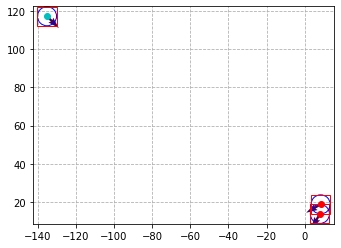



state:  2
0 x = -23.189358213140192
0 y = 5.3955378222861565
0 route = 315
0 mode = HIGH
0 time = 15.821512891446265


1 x = 0.0
1 y = 0.0
1 route = 240
1 mode = LOW
1 time = 15.821512891446265


2 x = -5.3955378222861565
2 y = 10.791075644572313
2 route = 210
2 mode = LOW
2 time = 15.821512891446265




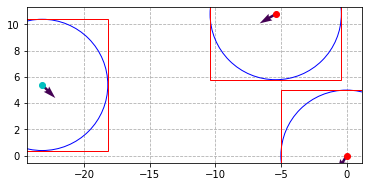



state:  3
0 x = -23.189358213140192
0 y = 5.3955378222861565
0 route = 315
0 mode = HIGH
0 time = 15.821512891446265


1 x = 0.0
1 y = 0.0
1 route = 240
1 mode = HIGH
1 time = 15.821512891446265


2 x = -5.3955378222861565
2 y = 10.791075644572313
2 route = 210
2 mode = HIGH
2 time = 15.821512891446265




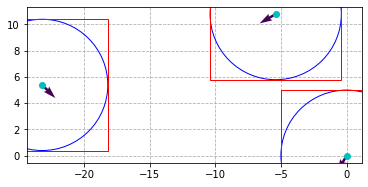



state:  4
0 x = -23.189358213140192
0 y = 5.3955378222861565
0 route = 315
0 mode = HIGH
0 time = 15.821512891446265


1 x = 0.0
1 y = 0.0
1 route = 240
1 mode = HIGH
1 time = 15.821512891446265


2 x = -5.3955378222861565
2 y = 10.791075644572313
2 route = 210
2 mode = HIGH
2 time = 15.821512891446265




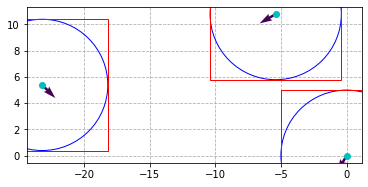



state:  5
0 x = -20.392483449597183
0 y = 2.5986630587431474
0 route = 315
0 mode = HIGH
0 time = 16.21705071373242


1 x = -1.9776891114307846
1 y = -3.4254580225738627
1 route = 240
1 mode = HIGH
1 time = 16.21705071373242


2 x = -8.82099584486002
2 y = 8.81338653314153
2 route = 210
2 mode = HIGH
2 time = 16.21705071373242




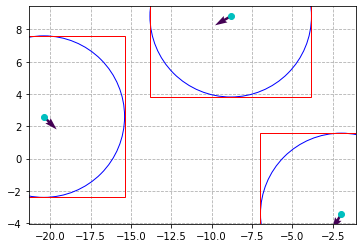



state:  6
0 x = -12.76597955460883
0 y = -5.02784083624521
0 route = 315
0 mode = HIGH
0 time = 17.295601237910795


1 x = -7.370441732322672
1 y = -12.76597955460883
1 route = 240
1 mode = HIGH
1 time = 17.295601237910795


2 x = -18.161517376894988
2 y = 3.420633912249645
2 route = 210
2 mode = HIGH
2 time = 17.295601237910795




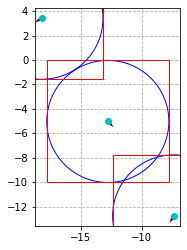



state:  7
0 x = -9.969104791065822
0 y = -7.82471559978822
0 route = 315
0 mode = HIGH
0 time = 17.691139060196956


1 x = -9.348130843753458
1 y = -16.191437577182693
1 route = 240
1 mode = HIGH
1 time = 17.691139060196956


2 x = -21.586975399468848
2 y = 1.4429448008188615
2 route = 210
2 mode = HIGH
2 time = 17.691139060196956




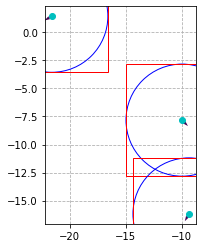

In [20]:



def printState(s):
    infs = [getShipInf(s[ship]) for ship in s]
    ax = plt.axes()
    
    for i,t in enumerate(infs):
        if t[4] == 1:
            plt.plot(t[0],t[1], color='c', marker='o', label = str(i))
        
        elif t[4] == 2:
            plt.plot(t[0],t[1], color='b', marker='o', label = str(i))

        else:
            plt.plot(t[0],t[1], color='r', marker='o', label = str(i))
        

        ax.quiver(*t,units='xy')
        circle = plt.Circle((t[0],t[1]), risk, color='b', fill=False)
        sq = plt.Rectangle((t[0]-risk,t[1]-risk), risk*2,risk*2, color='r', fill=False)
        #ax.set_aspect('equal')
        #ax.set_aspect('auto')
        ax.set_aspect('equal', adjustable='box')
        #ax.set_aspect('equal', 'datalim')
        #plt.axis('scaled')
        ax.add_artist(circle)
        ax.add_artist(sq)
    plt.grid()
    plt.grid(linestyle='--')
    ax.set_axisbelow(True)
    plt.show()
    pass



def getShipInf(ship):
    a = [ship['x'],ship['y']]
    
    v = ship['vel']
    inc = ship['route']
    x2 = 5 * cosseno(inc)
    y2 = 5 * seno(inc)
    b = [x2,y2]
    return (a[0],a[1],b[0],b[1],v)




def gera_tracoAnim(declare,init,trans,k):
    trace = [declare(i) for i in range(k)]
    s = Solver()
    
    s.add(init(trace[0]))
    
    for i in range(k):
        pred = [trace[i][ship]['time'] == trace[i][ship+1]['time'] for ship in range(ships-1)]
        s.add(And(pred))

    for i in range(k-1):
        s.add(trans(trace[i],trace[i+1]))
    
    r = s.check()
    if r == sat:
        m = s.model()
        state = {}
        for i in range(k):
            print("==========\n\n\nstate: ",i)
            for v in trace[i]:
                state[v] = {}
                for h in trace[i][v]:
                    if trace[i][v][h].sort() != RealSort():
                        print(v,h, "=", m[trace[i][v][h]])

                        if(trace[i][v][h].sort() == Mode):
                            if (m[trace[i][v][h]] == INIT):
                                state[v]['vel'] = 2

                            elif (m[trace[i][v][h]] == LOW):
                                state[v]['vel'] = 0

                            elif (m[trace[i][v][h]] == HIGH):
                                state[v]['vel'] = 1

                        else:
                            state[v][h] = m[trace[i][v][h]].as_long()
                    
                    else:
                        print(v,h, '=', float(m[trace[i][v][h]].numerator_as_long())/float(m[trace[i][v][h]].denominator_as_long()))
                        state[v][h] = float(m[trace[i][v][h]].numerator_as_long())/float(m[trace[i][v][h]].denominator_as_long())               
                print("\n")
            printState(state)
        return
    
    print('UNSAT')
    return 


gera_tracoAnim(declare,init,trans,8)

Nesta representação, o estado de velocidade de um navio é representado por sua cor, assim as cores do autómato já apresentado (ciano = *HIGH*, vermelho = *LOW* e azul = *INIT*). As circunferências azuis representam a distância de segurança estimada, enquanto os quadrados vermelhos representam a distância de segurança real analisada por cada navio.

Vale ressaltar que, por todas as alterações realizadas, os resultados aqui ilustrados são apenas algumas ilustrações e podem não representar com fidelidade execuções reais do modelo até então apresentado.